In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.ar_model import AutoReg

In [30]:
window = 20
file_path = './in/copper_log_returns_{}d_final.csv'.format(window)
targ = 'LMCADY_acu_{}d_log'.format(window)

df = pd.read_csv(file_path, parse_dates=True)

df = df.sort_values(by='Date')

time_series = df[targ]

time_series

0       0.081352
1       0.075898
2       0.068538
3       0.055772
4       0.046443
          ...   
5530    0.055556
5531    0.053156
5532    0.073317
5533    0.088143
5534    0.112357
Name: LMCADY_acu_20d_log, Length: 5535, dtype: float64

In [31]:
LMCADY_train, LMCADY_test = train_test_split(time_series, test_size=0.03, shuffle=False)
LMCADY_train

0       0.081352
1       0.075898
2       0.068538
3       0.055772
4       0.046443
          ...   
5363   -0.023912
5364   -0.036150
5365   -0.056180
5366   -0.021553
5367   -0.002801
Name: LMCADY_acu_20d_log, Length: 5368, dtype: float64

In [32]:
print(LMCADY_test.head())
LMCADY_test.tail()

5368   -0.019559
5369   -0.005176
5370    0.000135
5371    0.021388
5372   -0.000539
Name: LMCADY_acu_20d_log, dtype: float64


5530    0.055556
5531    0.053156
5532    0.073317
5533    0.088143
5534    0.112357
Name: LMCADY_acu_20d_log, dtype: float64

In [33]:
def evaluate_ar_model(train_series, test_series, lags=5):

    if not isinstance(train_series.index, pd.DatetimeIndex):
        train_series.index = pd.RangeIndex(start=0, stop=len(train_series))

    predictions = []

    current_train = train_series.copy()
    for actual in test_series:
        if len(current_train) <= lags:
            print(f"No hay suficientes observaciones para {lags} lags. Terminando el ciclo.")
            break

        model = AutoReg(current_train, lags=lags)
        model_fit = model.fit()

        prediction = model_fit.predict(start=len(current_train), end=(len(current_train)+window-1), dynamic=False)

        # print(prediction)

        predictions.append(prediction.iloc[-1])
        # print("pred {:.6f}, {:.6f}".format(prediction.iloc[-1],actual))

        current_train = pd.concat([current_train, pd.Series([actual], index=[len(current_train)])])

    return pd.Series(predictions, index=test_series.index)

In [34]:
def calculate_rmse(predictions, actual):

    # Asegurarse de que las series sean de igual longitud
    if len(predictions) != len(actual):
        raise ValueError("Las predicciones y los valores reales deben tener la misma longitud.")

    # Calcular el RMSE
    mse = mean_squared_error(predictions, actual)
    rmse = np.sqrt(mse)
    return rmse

In [35]:
stop_lag = 100

best_predictions = None
best_lags = None
best_rmse = float("inf")

# shift the test window values to the left and 

LMCADY_test_orig = LMCADY_test.copy()

LMCADY_test = LMCADY_test.shift(-window)
LMCADY_test.dropna(inplace=True)

for lags in range(1,stop_lag+1,1):
    LMCADY_predictions = evaluate_ar_model(LMCADY_train, LMCADY_test_orig, lags=lags)

    LMCADY_predictions = LMCADY_predictions[:-window]
    
    LMCADY_rmse = calculate_rmse(LMCADY_predictions, LMCADY_test)
    print(f"AR> RMSE {lags} lags: {LMCADY_rmse:.6f}")

    if LMCADY_rmse < best_rmse:
        best_rmse = LMCADY_rmse
        best_lags = lags
        best_predictions = LMCADY_predictions


AR> RMSE 1 lags: 0.036887
AR> RMSE 2 lags: 0.037058
AR> RMSE 3 lags: 0.037030
AR> RMSE 4 lags: 0.036938
AR> RMSE 5 lags: 0.036785
AR> RMSE 6 lags: 0.036617
AR> RMSE 7 lags: 0.036626
AR> RMSE 8 lags: 0.036439
AR> RMSE 9 lags: 0.036341
AR> RMSE 10 lags: 0.036262
AR> RMSE 11 lags: 0.036089
AR> RMSE 12 lags: 0.036009
AR> RMSE 13 lags: 0.035876
AR> RMSE 14 lags: 0.035858
AR> RMSE 15 lags: 0.035651
AR> RMSE 16 lags: 0.035596
AR> RMSE 17 lags: 0.035513
AR> RMSE 18 lags: 0.035449
AR> RMSE 19 lags: 0.035338
AR> RMSE 20 lags: 0.035280
AR> RMSE 21 lags: 0.038845
AR> RMSE 22 lags: 0.039093
AR> RMSE 23 lags: 0.039253
AR> RMSE 24 lags: 0.039270
AR> RMSE 25 lags: 0.039216
AR> RMSE 26 lags: 0.039296
AR> RMSE 27 lags: 0.039297
AR> RMSE 28 lags: 0.039040
AR> RMSE 29 lags: 0.038601
AR> RMSE 30 lags: 0.038624
AR> RMSE 31 lags: 0.038340
AR> RMSE 32 lags: 0.038094
AR> RMSE 33 lags: 0.037713
AR> RMSE 34 lags: 0.037736
AR> RMSE 35 lags: 0.037622
AR> RMSE 36 lags: 0.037573
AR> RMSE 37 lags: 0.037469
AR> RMSE 3

In [36]:
std_prueba = LMCADY_test.describe()['std']
print("El mejor rendimiento: {} lags, rmse = {:.6f} vs. std = {:.6f}".format(best_lags,best_rmse,std_prueba))
# print("Predicciones:")
# print(best_predictions)

El mejor rendimiento: 20 lags, rmse = 0.035280 vs. std = 0.035978


In [37]:
best_predictions

5368    0.017204
5369    0.012396
5370    0.018457
5371    0.021572
5372    0.030544
          ...   
5510    0.022927
5511    0.024451
5512    0.014053
5513    0.007111
5514    0.005384
Length: 147, dtype: float64

In [38]:
LMCADY_test

5368   -0.028660
5369   -0.031965
5370   -0.055969
5371   -0.067478
5372   -0.059616
          ...   
5510    0.055556
5511    0.053156
5512    0.073317
5513    0.088143
5514    0.112357
Name: LMCADY_acu_20d_log, Length: 147, dtype: float64

In [39]:
# # print both series side by side with both indexes
# for i in range(len(LMCADY_test)):
#     print("Pred {:.6f}, Actual {:.6f}".format(best_predictions.iloc[i],LMCADY_test.iloc[i]))

In [40]:
def plot_predictions(test_series, predictions, title, best_lags, markersize=3):
    plt.figure(figsize=(14, 3))

    plt.plot(test_series.index, test_series, label="Actual", marker='o', linestyle='-', markersize=markersize)
    plt.plot(test_series.index, predictions, label="Predicted", marker='x', linestyle='--', markersize=markersize)
    plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.7)


    plt.title(f"AR Model: {title} - {best_lags} lags")
    plt.legend()
    plt.show()

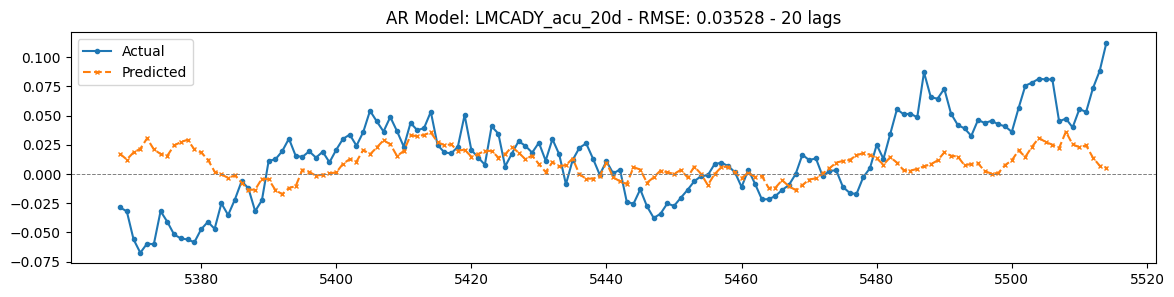

In [41]:
plot_predictions(LMCADY_test, best_predictions, "LMCADY_acu_{}d - RMSE: {:.5f}".format(window, best_rmse), best_lags, markersize=3)

In [42]:
"{:.5f} {:.5f}".format(std_prueba,best_rmse)

'0.03598 0.03528'